In [1]:
%autosave 0
import numpy as np
import pandas as pd

Autosave disabled


# <center>Data Overview</center>

In [2]:
# https://www.kaggle.com/datasets/mukeshmanral/univariate-time-series
ts = pd.read_csv('date_count.csv')

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    578 non-null    object
 1   count   578 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


In [4]:
ts

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


### Preprocessing

In [5]:
ts['Date'] = pd.to_datetime(ts['Date'])
ts.set_index('Date', inplace=True)

### Time series plot

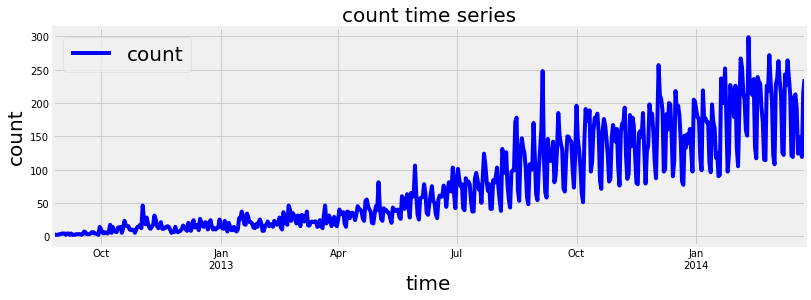

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

ts.plot(color='blue')
plt.title('count time series', size=20)
plt.xlabel('time', size=20)
plt.ylabel('count', size = 20)
plt.gcf().set_size_inches(12, 4)
plt.legend(loc=2, prop={'size': 20})

### Time series decomposition

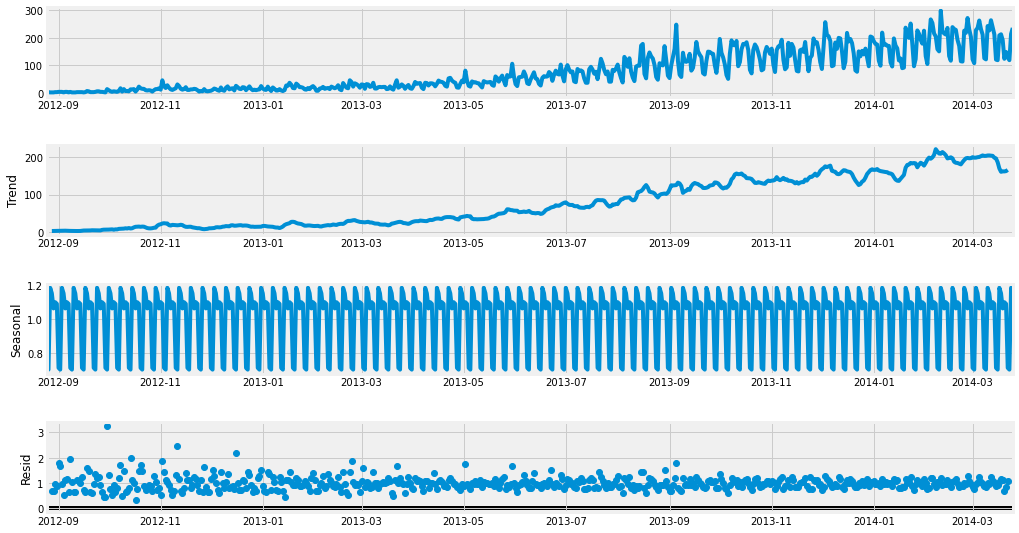

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.asfreq('D')
decompose = seasonal_decompose(ts, model='multiplicative')
decompose.plot()
plt.gcf().set_size_inches(16, 8)
plt.show()

Let's have a closer look at the seasonality.

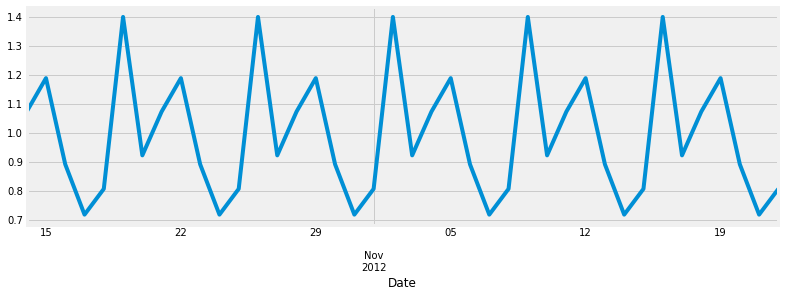

In [8]:
magified_seasonality = ts.iloc[50:90]
magified_seasonality.asfreq('D')
decomp = seasonal_decompose(magified_seasonality, model='multiplicative')
decomp.seasonal.plot()
plt.gcf().set_size_inches(12, 4)
plt.show()

It is now evident that weekly seasonality is present.

# <center>Multi-step 60-day forecast (fh = 60)</center>

### Data preparation

In [9]:
from kats.consts import TimeSeriesData

ts.reset_index(inplace=True)
ts.columns = ['time','value']
count_ts = TimeSeriesData(ts)

### Train / test split

In [10]:
y_train = count_ts[:len(count_ts)-60]
y_test = ts[len(count_ts)-60:]

### Training the model

In [11]:
from kats.models.prophet import ProphetModel, ProphetParams

params = ProphetParams(seasonality_mode='multiplicative')
m = ProphetModel(y_train, params)
m.fit()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecasting

In [12]:
fcst = m.predict(steps=60, freq="D")

In [13]:
fcst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        60 non-null     datetime64[ns]
 1   fcst        60 non-null     float64       
 2   fcst_lower  60 non-null     float64       
 3   fcst_upper  60 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.0 KB


### Evaluation

In [14]:
fcst.set_index('time', inplace=True)
y_test.set_index('time', inplace=True)
evaluation_df = fcst.assign(y_test=y_test['value'])
evaluation_df.columns

Index(['fcst', 'fcst_lower', 'fcst_upper', 'y_test'], dtype='object')

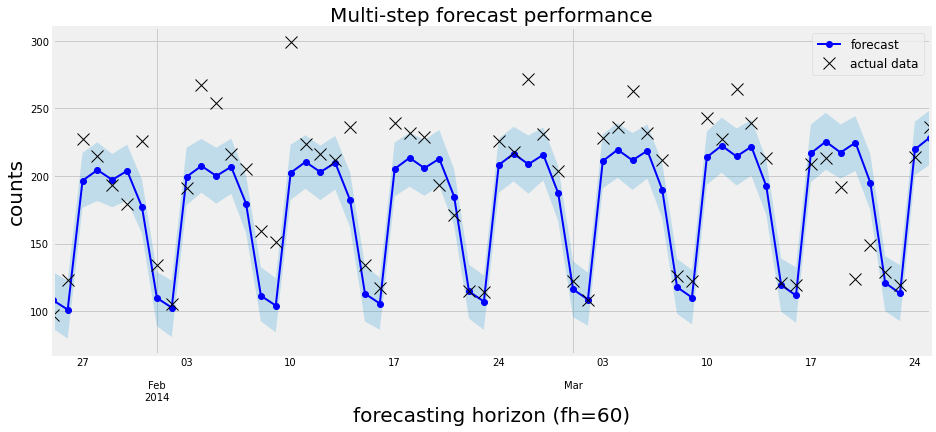

In [15]:
plt.figure()
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('Multi-step forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=60)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=1, prop={'size': 12})
plt.show()

In [16]:
def evaluation_metrics(y_test, y_pred, model_name):
    MAPE = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'Model':model_name, 'MAPE':round(MAPE,3), 'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'], 'ProphetModel')
print(accuracy)

{'Model': 'ProphetModel', 'MAPE': 11.827, 'RMSE': 31.406, 'MAE': 22.817}


In [17]:
performance_summary_fh60 = pd.DataFrame()
performance_summary_fh60 = performance_summary_fh60.append(accuracy, ignore_index=True)
performance_summary_fh60.to_csv('performance_summary_fh60.csv', index=False)

# <center>Rolling 1-day forecasting (fh=1)</center>

### Training / Forecasting

In this setup, training and forecasting is conducted one after another while the training data grows successively by 1 day.

In [18]:
evaluation_df = pd.DataFrame()
split = len(count_ts)-60
params = ProphetParams(seasonality_mode='multiplicative')

while split < len(count_ts):
    m = ProphetModel(count_ts[:split], params)
    m.fit()
    fcst = m.predict(steps=1, freq="D")
    evaluation_df = evaluation_df.append(fcst, ignore_index=True)
    split += 1 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

### Evaluation

In [19]:
evaluation_df.set_index('time', inplace=True)
evaluation_df = evaluation_df.assign(y_test=y_test['value'])

In [20]:
evaluation_df.columns

Index(['fcst', 'fcst_lower', 'fcst_upper', 'y_test'], dtype='object')

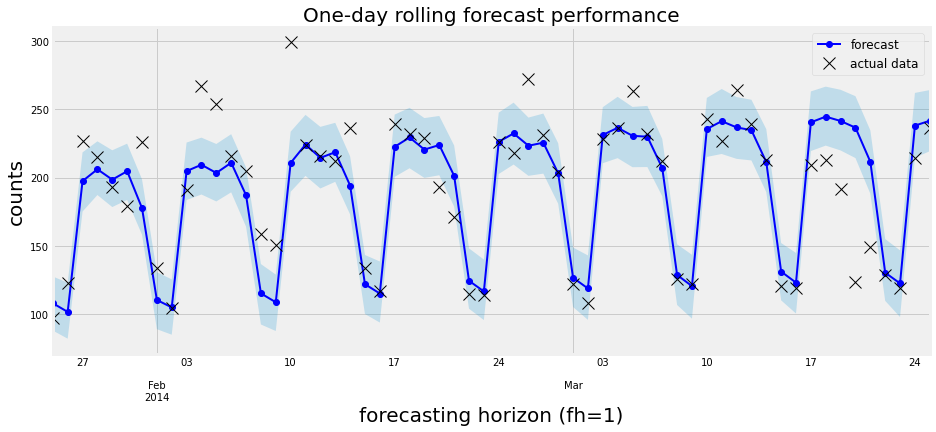

In [21]:
plt.figure()
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('One-day rolling forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=1)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=1, prop={'size': 12})
plt.show()

In [22]:
accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'], 'ProphetModel')
print(accuracy)

{'Model': 'ProphetModel', 'MAPE': 10.621, 'RMSE': 29.962, 'MAE': 19.699}


In [23]:
performance_summary_fh1 = pd.DataFrame()
performance_summary_fh1 = performance_summary_fh1.append(accuracy, ignore_index=True)
performance_summary_fh1.to_csv('performance_summary_fh1.csv', index=False)